# Azimuth compression
In this notebook we first tryout the Range Cell Migration correction, then we apply azimuth compression on the range compressed data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

c = 299792458 # m/s
range_compressed = np.load('../data/range_compressed.npy')

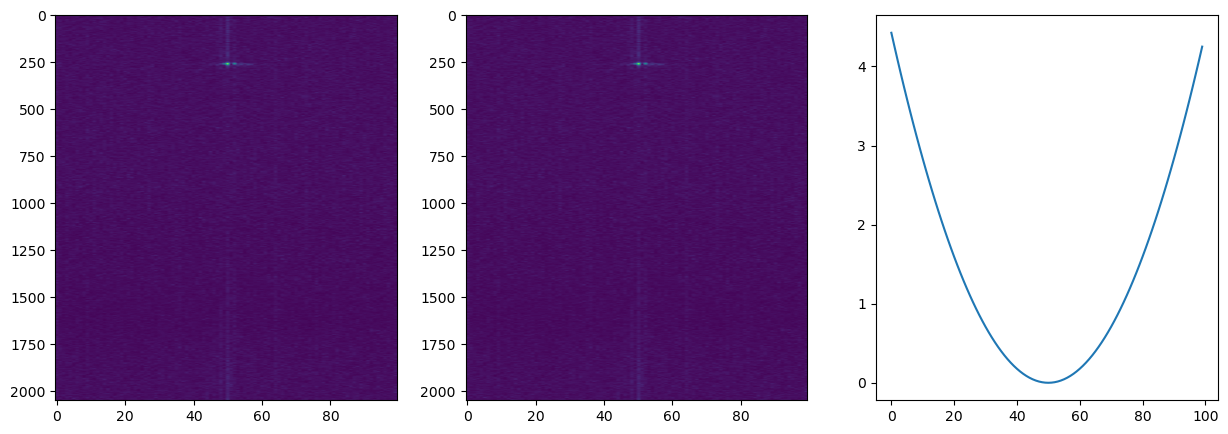

In [ ]:
#ADC samples at 80/3 MHz

c = 299792458 # m/s
f = 80e6/3 # Hz, Sampling Frequency
R = 315e3 # m, Height of SC, also used as slant range
v = 3.397e3 # m/s, SC velocity


dr = c/(2 * 10e6 * np.sqrt(3.15)) # c / (2 * Bandwidth * sqrt(3.15))
PRF = 135 # or 350
SF = 80e6/3

# Aperture in number of pixels
# Idx is the index of the zero doppler (center column of the window being processed)
idx = 6000
aperture = 2000
T = (1/PRF) * aperture
print('Time of aperture: {}s'.format(T))

# Window of the radargram being processed
image = range_compressed[:,idx-aperture//2:idx+aperture//2]

def rcm(image):
    fft = np.fft.fftshift(np.fft.fft(image, axis = 1),axes = 1) # Azimuth FFT

    # Range independent migration
    # Create empty variables
    post_rcm = np.zeros_like(fft)
    shifts = []
    tt = []
    for i in range(fft.shape[1]):
        t = i*(T/fft.shape[1]) - (T/fft.shape[1])*(fft.shape[1]//2)
        tt.append(t)
        shift_in_m = (v*t)**2/R # Shift in meters
        shift_in_t = shift_in_m/(c/np.sqrt(3.15)) # Shift in seconds
        shift_in_px = shift_in_t/(1/SF) # Shift in pixels
        shifts.append(shift_in_px)
        # Roll each column by its shift in pixels
        post_rcm[:,i] = np.roll(fft[:,i], shift = -int(np.round(shift_in_px)), axis = 0)
    
    # Plots
    plt.figure(figsize = (15,5))
    plt.subplot(131)
    plt.imshow(np.abs(fft)[:500,:], aspect='auto')
    plt.subplot(132)
    plt.imshow(np.abs(post_rcm)[:500,:], aspect='auto')
    plt.subplot(133)
    plt.plot(tt,shifts)
    return image, post_rcm

pre,post = rcm(image)

In [5]:
# Azimuth Compression
# In this cell we test the function, in the next one we apply on the radargram with a for loop
# Test on the following window
idx = 5000
aperture = 1000
image = range_compressed[:,idx-aperture//2:idx+aperture//2]

# Some are redefined
Bw = 10e6 # MHz
PRF = 135 # Hz, 700/4 presummed
SF = 80e6/3 # Hz, 80/3 MHz
H = 315e3 # m, altitude
V = 3.397e3 # m/s
lbd = c/20e6 # central wavelength
dx = c/(2*Bw*np.sqrt(3.15))

def focus(radargram, verbose = False):
    _, nLines = radargram.shape
    T = nLines/PRF # Time of aperture in seconds
    t = np.linspace(-T/2,T/2,nLines)

    # RCM (as per cell above)
    rg_fft = np.fft.fftshift(np.fft.fft(radargram, axis = 1), axes = 1)
    shifts = (V*t)**2/(2*H) # m
    shifts_in_pixels = -np.round(shifts/dx).astype(int)*10
    rg_fft_shifted = np.zeros_like(rg_fft)
    for i in range(nLines):
        rg_fft_shifted[:,i] = np.roll(a = rg_fft[:,i], shift = shifts_in_pixels[i], axis = 0)

    # AZC (azimuth compression)
    k = -2 * (V**2) / (lbd*H) # Slope of Doppler frequency
    fd = k * t # Doppler frequency vs time
    azref = np.exp(1j * np.pi * fd * t) # Azimuth reference function with given (Doppler) frequency
    azref_fft = np.fft.fftshift(np.fft.fft(azref)) # FFT of azimuth reference function
    rg_focused_fft = rg_fft_shifted * np.conj(azref_fft) # Correlation of reference and signal in freq domain
    rg_focused = np.fft.ifft(np.fft.fftshift(rg_focused_fft, axes = 1))
    #rg_focused = np.sum(rg_focused, axis = 1)
    
    if verbose:
        plt.figure(figsize = (20,5))
        plt.subplot(131)
        plt.plot(np.real(azref),'-')
        plt.subplot(132)
        plt.plot(np.real(azref_fft),'-')
        plt.subplot(133)
        plt.imshow(np.abs(rg_focused), aspect = 'auto')
    return rg_focused

# Test the function on the window
image = range_compressed[:,idx-aperture//2:idx+aperture//2]
rg_focused = focus(image, verbose = True)
print(rg_focused.shape)

(2048,)


In [11]:
# Apply azimuth compression on bigger portions of the radargram
START_COLUMN = 45000
STOP_COLUMN = 50000
APERTURE = 1000

focused = np.zeros_like(range_compressed)

for i in range(START_COLUMN, STOP_COLUMN):
    print('Column',i)
    image = range_compressed[:,i-APERTURE//2:i+APERTURE//2]
    focused[:,i-aperture//2:i+aperture//2] += focus(image)


45000
45001
45002
45003
45004
45005
45006
45007
45008
45009
45010
45011
45012
45013
45014
45015
45016
45017
45018
45019
45020
45021
45022
45023
45024
45025
45026
45027
45028
45029
45030
45031
45032
45033
45034
45035
45036
45037
45038
45039
45040
45041
45042
45043
45044
45045
45046
45047
45048
45049
45050
45051
45052
45053
45054
45055
45056
45057
45058
45059
45060
45061
45062
45063
45064
45065
45066
45067
45068
45069
45070
45071
45072
45073
45074
45075
45076
45077
45078
45079
45080
45081
45082
45083
45084
45085
45086
45087
45088
45089
45090
45091
45092
45093
45094
45095
45096
45097
45098
45099
45100
45101
45102
45103
45104
45105
45106
45107
45108
45109
45110
45111
45112
45113
45114
45115
45116
45117
45118
45119
45120
45121
45122
45123
45124
45125
45126
45127
45128
45129
45130
45131
45132
45133
45134
45135
45136
45137
45138
45139
45140
45141
45142
45143
45144
45145
45146
45147
45148
45149
45150
45151
45152
45153
45154
45155
45156
45157
45158
45159
45160
45161
45162
45163
45164
45165
4516

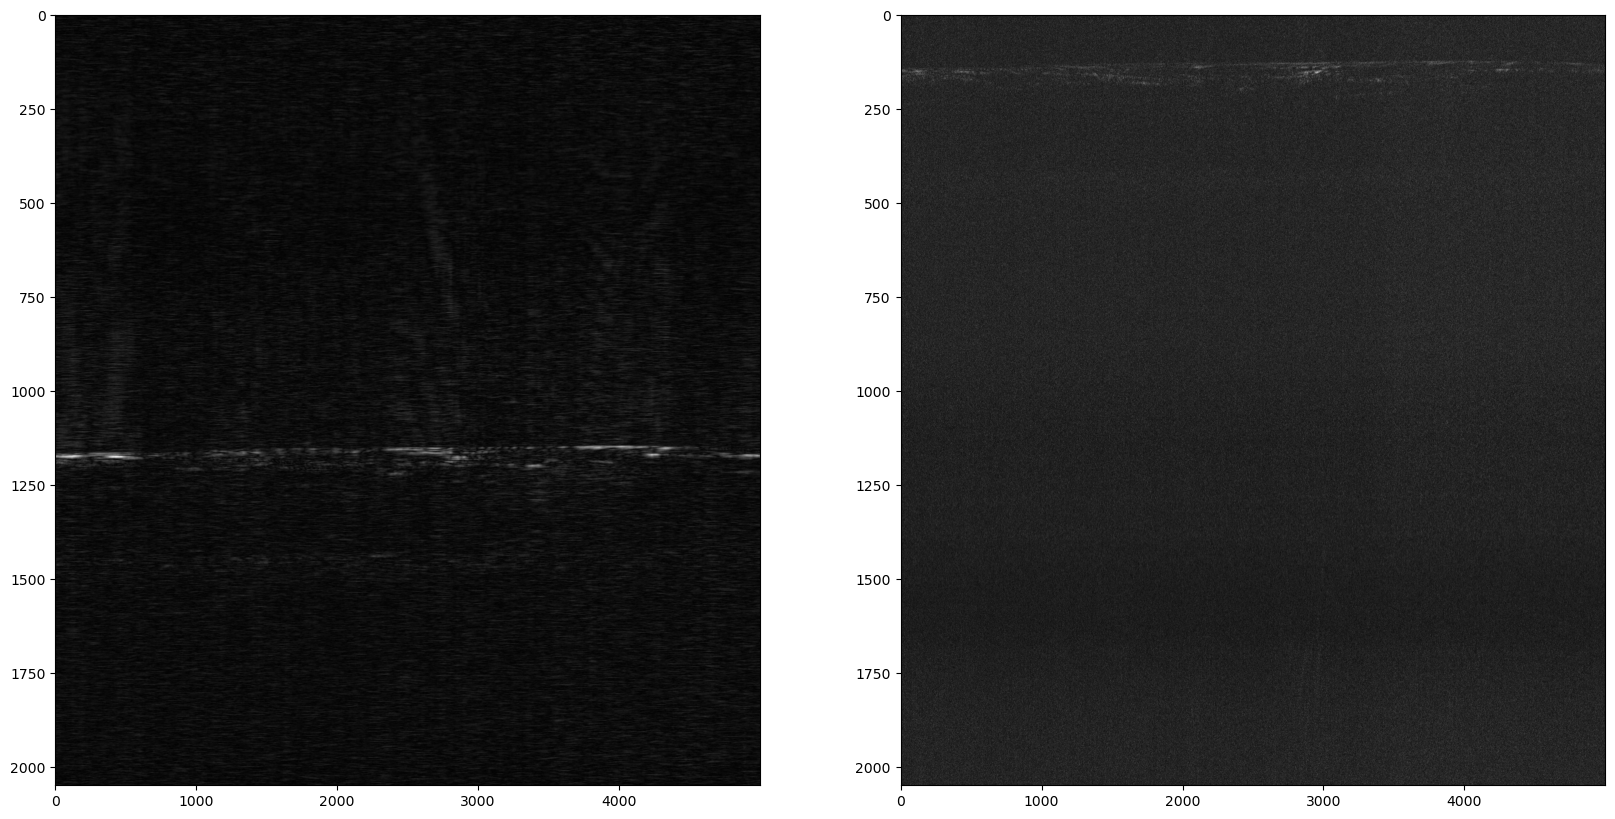

In [12]:
# Plot results and compare with range compressed only version
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(np.abs(focused[:,45000:50000]),aspect = 'auto', cmap = 'grey')
plt.subplot(122)
plt.imshow(np.abs(range_compressed[:,45000:50000]),aspect = 'auto', cmap='gray')